Create a dataset that can be visualized and therefore better understood using the preprocessing techniques I've learned 

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
FILENAME = 'NBADATA.csv'

In [3]:
data = pd.read_csv(FILENAME) 
data['3P%'] = np.divide(data['3P'].values,data['3PA'].values) 
del data['3P'],data['3PA']
data['FG%'] = np.divide(data['FG'].values,data['FGA'].values)
del data['FG'],data['FGA']
data['FT%'] = np.divide(data['FT'].values,data['FTA'].values)
del data['Unnamed: 0'],data['GAME_ID'],data['Date'],data['Home'],data['Away'],data['PLUS_MINUS'],data['TOTAL']
del data['FT'],data['FTA']
del data['OU']
del data['Team']
data = pd.get_dummies(data)

In [ ]:
data

In [ ]:
data.columns

In [4]:
road_df = data.iloc[::2]
home_df = data.iloc[1::2]
for col in data.columns:
    road_df['road_' + col] = road_df[col]
    home_df['home_' + col] = home_df[col]
    
    del road_df[col],home_df[col]

home_df.reset_index(inplace=True)
road_df.reset_index(inplace=True)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
df = pd.concat([road_df,home_df],axis=1)
del df['index']

In [6]:
#roadpts = df['road_PTS']       #column of all the points scored by road team 
#homepts = df['home_PTS']
#endspreadS = roadpts-homepts  #all the final spreads of the game


df['final_SPREAD'] = df['road_PTS'] - df['home_PTS']
del df['road_PTS'], df['home_PTS'],df['home_SPREAD']
           # if openspread + endspread <0:
            #    y.append(np.array([0,1,0]))  #home team covered
            #elif openspread + endspread >0:
            #    y.append(np.array([1,0,0]))  #road covered
           # else: 
           #     y.append(np.array([0,0,1]))  #push!
y = []
for i in range(len(df)):
    if df['road_SPREAD'].values[i] + df['final_SPREAD'].values[i] < 0:
        y.append(1) #home team covers
    else: # df['road_SPREAD'].values[i] + df['final_SPREAD'].values[i] > 0:
        y.append(0) #road team covers or push
    #else:
    #    y.append(np.array([0,1]))  #push! 

del df['final_SPREAD']


In [15]:
y_names = np.array(['road team', 'home team'])

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(df.values,y,random_state = 42)

In [17]:
print(X_train.shape)


(4906, 21)


In [18]:
scaler = MinMaxScaler()

In [19]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [20]:
X_train = scaler.transform(X_train)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
X_pca = pca.transform(X_train)


In [29]:
len(X_pca[:,1])

4906

In [30]:
len(X_pca[:,0])

4906

In [31]:
len(y)

6542

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

import mglearn

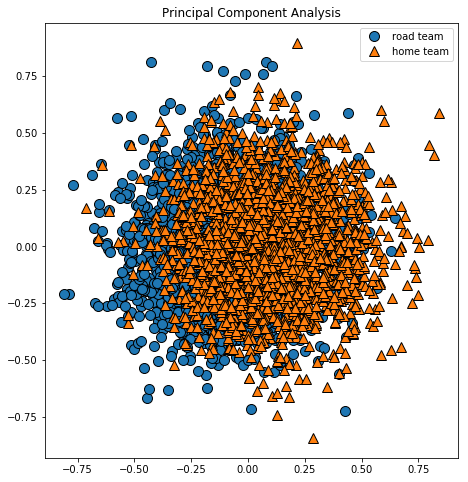

In [39]:
plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:,0],X_pca[:,1],y_train)
plt.legend(y_names,loc='best')
plt.gca().set_aspect('equal')
plt.title('Principal Component Analysis')

There is a little bit of separation, meaning there is something to exploit! By examining the features below, we can see which play the biggest role, and could be responsible for this...

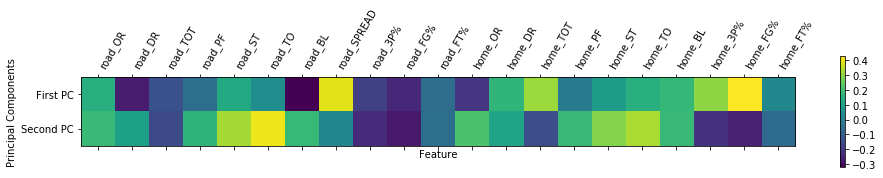

In [40]:
plt.figure()
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1],['First PC','Second PC'])
plt.colorbar()
plt.xticks(range(len(np.array(df.columns))),np.array(df.columns),rotation=60,ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal Components')

Based on this it appears the first PC is mainly rooted in the field goal %, given the home fg% is the most important, followed by spread it seems. 

In [ ]:
dat = []
    
    #reshape the dataset so now each colummn has roadstats and homestats concatenated into the same row, used for NN 
    
    for i in range(len(data.values)):
        data.values[i] = np.reshape(data.values[i],newshape=[1,len(data.values[i])])
    
    for p in range(int(len(data.values)/2)):
        fullboxgame = np.concatenate((data.values[2*p],data.values[(2*p)+1]))
        dat.append(fullboxgame)
    
    #convert list to array, now possible to array operations previously not possible
    dat = np.array(dat)   
    
    openingspreadS = dat[:,8] #what the predicted spread of ther game was. 

In [37]:
np.array(df.columns)

array(['road_OR', 'road_DR', 'road_TOT', 'road_PF', 'road_ST', 'road_TO',
       'road_BL', 'road_SPREAD', 'road_3P%', 'road_FG%', 'road_FT%',
       'home_OR', 'home_DR', 'home_TOT', 'home_PF', 'home_ST', 'home_TO',
       'home_BL', 'home_3P%', 'home_FG%', 'home_FT%'], dtype=object)

In [33]:
cancer = load_breast_cancer()

In [35]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'], 
      dtype='<U23')

In [13]:
y_names = np.array(['road team', 'home team'])

In [14]:
y_names

array(['road team', 'home team'], 
      dtype='<U9')